<h1> Feature engineering <br>
Modelling <br>
and Evaluation</h2>
<br>
<br>
<b> This is work in progress! </b> <p> Next up is making the pipeline more automated. Scaling the targets. And finetune  the  LSTM, which architeture should it have. How many lags, how many LSTM units, how many  layers, how many perceptrons, which activation functions, and which special layers to add to the architecture. 
<br>
<br>
Radical change: use NIBOR in stead of interest rate, because it is update daily and can give better results.
<h4> Readying the forecast dataset </h4>
Use Ohrnstein Uhlenbeck process to find Food_index price. Use SSB/NB to find forecasts for policy rate. Find some forecasts or eventually use OU-process to find the FX.

<!-- <ol>
<li>Deterministic process</li>
<li>Lagged variables</li>
<li> Fourier</li>
<li>Seasonal indicators (very important)</li>
<li></li>
<li></li>
<li></li>
</ol> -->

<h1> 1. Getting started </h1>
<h2> 1.1 Importing libraries </h2>

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer



import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, Input, callbacks
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import  CalendarFourier

<h2> 1.2 Downloading data </h2>

In [72]:
df = pd.read_csv('Preprocessed_data.csv')
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop(['Date'], axis=1, inplace=True)

<h2> 1.3 Splitting data in 3*2

In [73]:
y = df['Salmon_exp_vol']
X = df.loc[:,'FX_EURONOK':]

X_train, X_eval, y_train, y_eval = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, 
                                                test_size=0.5,
                                                shuffle=False)

In [182]:
np.linspace(1,52,52)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.])

In [183]:
def seasonal_indicators(X):
    # weeks = [1,2,3,4,5,6,42,43,44,45,46,47,48,49,50,51,52]
    weeks = np.linspace(1,52,52)
    indicator_df = pd.DataFrame()
    for ind_week in range(len(weeks)):
        column = np.where(X.index.isocalendar().week==weeks[ind_week],1,0)
        indicator_df['IndWeek'+str(weeks[ind_week])] = column
    indicator_df.index = X.index
    new_X = pd.concat([X, indicator_df],axis=1)
    return new_X
indicator_func = FunctionTransformer(func=seasonal_indicators)


<h1> 2. Feature engineering </h1>

<h2> 2.1 Manual imputing </h2>

In [153]:
X_train['FX_EURONOK']['2002-10-14'] = 7.34
X_train['FX_EURONOK']['2008-08-04'] = 7.9995
X_train['FX_EURONOK']['2008-08-08'] = 7.9915
X_train['FX_EURONOK']['2008-08-11'] = 7.9975
X_train['FX_EURONOK']['2008-08-18'] = 7.9740

<h2> 2.2 Time dummy and Fourier  </h2>

In [154]:
def det_process(X, startValue=None):
    fourier0  =  CalendarFourier(freq='A',  order=3)
    fourier1  =  CalendarFourier(freq='6M',  order=3)
    fourier2  =  CalendarFourier(freq='Q',  order=3)

    dp = DeterministicProcess(
        index=X.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier0,fourier1,fourier2],
        drop=True
    ) 
    dp = dp.in_sample()
    dp['trend'] += startValue
    new_X = pd.concat([X,dp], axis=1)
    return new_X
time_func = FunctionTransformer(func=det_process, 
                                kw_args={'startValue':None})


<h2> 2.3  Column specific engineering </h2>
<h3> 2.3.1 Log transformation </h3>

In [155]:
def log_transformation(X):
    X = np.log1p(X)
    X = pd.DataFrame(X)
    return X
log_func = FunctionTransformer(func=log_transformation)

<h3> 2.3.2 Lagging variables

In [156]:
def lagged_func_org(X, target=None):
    X_new =  pd.concat([target, X], axis=1)
    # lags = [[1,2,3,4],[13],[1,5],[1,2,3,4]]
    # shift_cols = ['Salmon_exp_vol', 'Interest_rate', 'Food_index', 'FX_EURONOK']
    lags = [[1]]
    shift_cols = ['Salmon_exp_vol']

    sec_it = 0
    lagged_df = pd.DataFrame()
    for n_col in range(len(shift_cols)):
        for n_lag  in range(len(lags[n_col])):
            sec_it+=1
            lagged_df[str(shift_cols[n_col]+
                      '_lag'+
                      str(lags[n_col][n_lag]))] = X_new[shift_cols[n_col]].shift(lags[n_col][n_lag])
    ldf = pd.concat([X,lagged_df],axis=1).dropna()
    return ldf

lagged_func = FunctionTransformer(func=lagged_func_org, 
                                  kw_args={'target':None})

<h2> 2.4  Z-scoring </h2>

In [158]:
zScore_func = StandardScaler()
zScoreTarget_func = StandardScaler()

<h2> 2.5 Reshaping 2d->3d array

In [159]:
def reshaper(X, timeSteps=None):
    X = pd.DataFrame(X)
    new_Xs = [np.array(X[timeSteps:])]
    print(X.shape)

    for i in range(1, timeSteps+1,1):
        shift_X  = np.array(X.shift(i))
        new_Xs.append(shift_X[timeSteps:])

    X_reshaped = np.stack(new_Xs, axis=1)
    return X_reshaped

reshape_func = FunctionTransformer(func=reshaper, kw_args={'timeSteps':None})


<h1> 3. LSTM model </h1>

In [218]:
model = keras.Sequential([
    layers.LSTM(127, input_shape=(14,127)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='LeakyReLU'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='gelu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='selu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam',
            #   loss=keras.losses.MeanSquaredError()
              loss = 'mae'
              )

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=30, # how many epochs to wait before stopping
    restore_best_weights=True,
)

<h1> 4.  Pipelining </h1>
<h2> 4.1 Column specific pipeline </h2>

In [203]:
engineering_func = ColumnTransformer(
    transformers=[
        ('loger', log_func, ['FX_EURONOK']),
    ], remainder='passthrough')

<h2> 4.2 Total pipeline </h2>

In [204]:
X_val_corr = pd.concat([X_train[-15:],X_val])
X_test_corr = pd.concat([X_val[-15:],X_test])

(135, 3)

In [207]:
pipe = Pipeline(steps=[
    ('det', time_func),
    ('ind', indicator_func),
    ('lag', lagged_func),
    ('Col_spec', engineering_func),
    ('zScore_func', zScore_func),
    ('res', reshape_func)
    # ('lstm', model)
])


pipe.set_params(
                det__kw_args={'startValue':0},
                lag__kw_args={'target':y_train},
                res__kw_args={'timeSteps':13}
                )
X_train_preprocessed  = pipe.fit_transform(X_train)

pipe.set_params(det__kw_args={'startValue':960}, 
                lag__kw_args={'target':y_val},
                res__kw_args={'timeSteps':13})
X_val_preprocessed  = pipe.transform(X_val_corr)

pipe.set_params(det__kw_args={'startValue':1080}, 
                lag__kw_args={'target': y_test},
                res__kw_args={'timeSteps':13})
X_test_preprocessed  = pipe.transform(X_test_corr)


(959, 127)
(119, 127)
(119, 127)


<h1> X. Rest are drafts.. </h1>

In [223]:
target_scaler = StandardScaler()
y_train_pre = target_scaler.fit_transform(np.array([y_train[14:]]).T)
y_val_pre = target_scaler.transform(np.array([y_val[14:]]).T)
y_test_pre = target_scaler.transform(np.array([y_test[14:]]).T)

y_train_pre = y_train[14:]
y_val_pre = y_val[14:]
y_test_pre =y_test[14:]

In [224]:
model.fit(X_train_preprocessed,y_train_pre,
          epochs=500, batch_size=8,
          validation_data=[X_val_preprocessed, y_val_pre],
          callbacks=early_stopping)


train_pred = model.predict(X_train_preprocessed)
val_pred = model.predict(X_val_preprocessed)
test_pred = model.predict(X_test_preprocessed)

Epoch 1/500
 16/119 [===>..........................] - ETA: 1s - loss: 3041.0554

119/119 [==============================] - 1s 12ms/step - loss: 2991.4397 - val_loss: 2559.4636
Epoch 2/500
119/119 [==============================] - 1s 9ms/step - loss: 2922.3232 - val_loss: 2313.4897
Epoch 3/500
119/119 [==============================] - 1s 10ms/step - loss: 2910.0173 - val_loss: 2873.9067
Epoch 4/500
119/119 [==============================] - 1s 8ms/step - loss: 2891.4646 - val_loss: 2784.0051
Epoch 5/500
119/119 [==============================] - 1s 9ms/step - loss: 2797.0957 - val_loss: 2727.9790
Epoch 6/500
119/119 [==============================] - 1s 9ms/step - loss: 2864.0227 - val_loss: 2949.2263
Epoch 7/500
119/119 [==============================] - 1s 11ms/step - loss: 2897.7703 - val_loss: 3515.0208
Epoch 8/500
119/119 [==============================] - 1s 9ms/step - loss: 2889.8545 - val_loss: 2312.4495
Epoch 9/500
119/119 [==============================] - 1s 9ms/step - loss: 2905.5605 - val_loss: 2227.1987
Epoch 10/500
119/119 [========================

In [210]:
# Good MAPE at un-scaled are: 15%
#scaled: 1.25

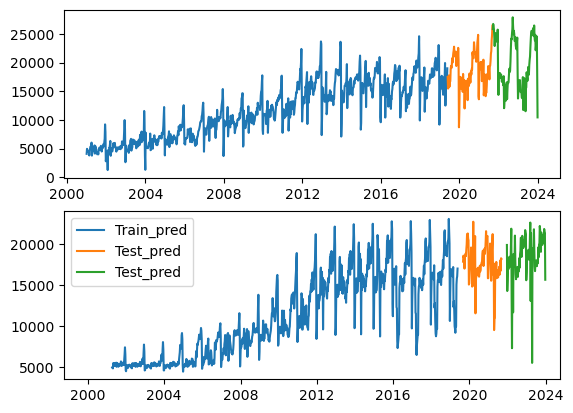

In [225]:
fig,ax = plt.subplots(2)
ax[0].plot(y_train, label='Train')
ax[0].plot(y_val, label='Valid')
ax[0].plot(y_test, label='Test')

ax[1].plot(X_train.index[14:], train_pred, label='Train_pred')
ax[1].set_xlim(10500,20000)
ax[1].plot(X_val.index[14:], val_pred, label='Test_pred')
ax[1].plot(X_test.index[14:], test_pred, label='Test_pred')

plt.legend()
plt.show()

In [212]:
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE


In [221]:
MAE(train_pred, y_train_pre)

1134.736746725522

In [214]:
str(X_train.size/1000)+ ' thousands'

'2.88 thousands'

In [215]:
# pd.DataFrame(X_train_preprocessed)

In [216]:
str(X_train_preprocessed.size/1000/1000) +' million'

'1.681988 million'